# Artifact Correction

In [2]:
import os
import pandas as pd

from PIL import Image

## Setup

In [3]:
root = '.'

base_file = f'{root}/base_proj_labels.csv'
label_file = f'{root}/proj_labels.csv'
image_dir = f'{root}/map-proj-v3_2'
temp_dir = f'{root}/tmp'

## Load Data

In [4]:
label_df = pd.read_csv(label_file)
base_df = pd.read_csv(base_file)

In [5]:
base_df.head()

,base,artifact,rect,angle
0,ESP_011289_1950_RED-0009.jpg,True,"[2, 5, 226, 178]",0
1,ESP_011289_1950_RED-0044.jpg,False,"[0, 0, 227, 227]",0
2,ESP_011289_1950_RED-0066.jpg,False,"[0, 0, 227, 227]",0
3,ESP_011289_1950_RED-0092.jpg,False,"[0, 0, 227, 227]",0
4,ESP_011289_1950_RED-0102.jpg,False,"[0, 0, 227, 227]",0


In [6]:
label_df.head()

,image,label,type
0,ESP_013049_0950_RED-0067.jpg,7,train
1,ESP_013049_0950_RED-0067-fv.jpg,7,train
2,ESP_013049_0950_RED-0067-brt.jpg,7,train
3,ESP_013049_0950_RED-0067-r90.jpg,7,train
4,ESP_013049_0950_RED-0067-r180.jpg,7,train


## Join Data

In [10]:
def get_baseimg(img: str) -> str:
    img = os.path.splitext(img)[0]
    parts = img.split('-')
    return f'{parts[0]}-{parts[1]}.jpg'

def get_transform(img: str) -> str:
    img = os.path.splitext(img)[0]
    ttype = img.split('-')[-1]
    return None if ttype.isdigit() else ttype

In [11]:
label_df['base'] = label_df['image'].apply(get_baseimg)
label_df['transform'] = label_df['image'].apply(get_transform)

In [15]:
df = pd.merge(label_df, base_df, how='inner', on='base')

In [16]:
df.head()

,image,label,type,base,transform,artifact,rect,angle
0,ESP_013049_0950_RED-0067.jpg,7,train,ESP_013049_0950_RED-0067.jpg,None,True,"[1, 0, 184, 149]",0
1,ESP_013049_0950_RED-0067-fv.jpg,7,train,ESP_013049_0950_RED-0067.jpg,fv,True,"[1, 0, 184, 149]",0
2,ESP_013049_0950_RED-0067-brt.jpg,7,train,ESP_013049_0950_RED-0067.jpg,brt,True,"[1, 0, 184, 149]",0
3,ESP_013049_0950_RED-0067-r90.jpg,7,train,ESP_013049_0950_RED-0067.jpg,r90,True,"[1, 0, 184, 149]",0
4,ESP_013049_0950_RED-0067-r180.jpg,7,train,ESP_013049_0950_RED-0067.jpg,r180,True,"[1, 0, 184, 149]",0


## Identify Artifacts

In [17]:
df_art = df[df['artifact'] == True]

In [18]:
df_art.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2731 entries, 0 to 15067
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   image      2731 non-null   object
 1   label      2731 non-null   int64 
 2   type       2731 non-null   object
 3   base       2731 non-null   object
 4   transform  2286 non-null   object
 5   artifact   2731 non-null   bool  
 6   rect       2731 non-null   object
 7   angle      2731 non-null   int64 
dtypes: bool(1), int64(2), object(5)
memory usage: 173.4+ KB


## Determine Transforms

Before we can apply the angle and cropping adjustments we need to factor in how the transforms change the angle and rects of the base artifact image

In [67]:
def transform_rect(shape: tuple, rect: list, ttype: str) -> list:
    w, h = shape

    if ttype == 'r90': # rotations are considered clockwise so this is actually 270
        return [h - rect[3], rect[0], h - rect[1], rect[2]]
    if ttype == 'r180':
        return [w - rect[2], h - rect[3], w - rect[0], h - rect[1]]
    if ttype == 'r270': # rotations are considered clockwise so this is actually 90
        return [rect[1], w - rect[2], rect[3], w - rect[0]]
    if ttype == 'fv':
        return [rect[0], h-rect[3], rect[2], h-rect[1]]
    if ttype == 'fh':
        return [w-rect[2], rect[1], w-rect[0], rect[3]]

    return rect

In [76]:
rect = [1, 0, 184, 149]
img_shape = (227, 227)

fv_rect = transform_rect(img_shape, rect, 'fv')
fh_rect = transform_rect(img_shape, rect, 'fh')
r90_rect = transform_rect(img_shape, rect, 'r90')
r180_rect = transform_rect(img_shape, rect, 'r180')
r270_rect = transform_rect(img_shape, rect, 'r270')
brt_rect = transform_rect(img_shape, rect, 'brt') # brightness shouldnt really cause a transform

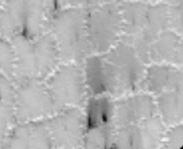

In [52]:
Image.open(os.path.join(image_dir, 'ESP_013049_0950_RED-0067.jpg')).convert('L').crop(rect)

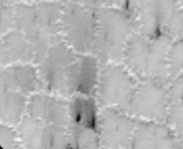

In [71]:
Image.open(os.path.join(image_dir, 'ESP_013049_0950_RED-0067-fh.jpg')).convert('L').crop(fh_rect)

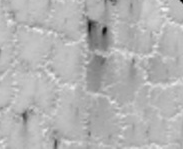

In [69]:
Image.open(os.path.join(image_dir, 'ESP_013049_0950_RED-0067-fv.jpg')).convert('L').crop(fv_rect)

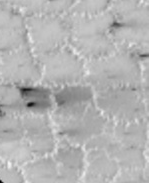

In [73]:
Image.open(os.path.join(image_dir, 'ESP_013049_0950_RED-0067-r90.jpg')).convert('L').crop(r90_rect)

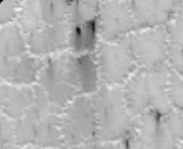

In [74]:
Image.open(os.path.join(image_dir, 'ESP_013049_0950_RED-0067-r180.jpg')).convert('L').crop(r180_rect)

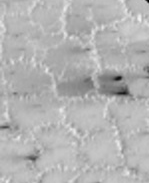

In [75]:
Image.open(os.path.join(image_dir, 'ESP_013049_0950_RED-0067-r270.jpg')).convert('L').crop(r270_rect)

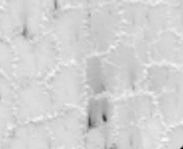

In [77]:
Image.open(os.path.join(image_dir, 'ESP_013049_0950_RED-0067-brt.jpg')).convert('L').crop(brt_rect)

This takes care of performing the basic transforms, but we also have to account the change in angle for certain images

In [80]:
df[df['angle'] != 0].head()

,image,label,type,base,transform,artifact,rect,angle
1113,ESP_016517_2655_RED-0026.jpg,7,train,ESP_016517_2655_RED-0026.jpg,None,True,"[62, 0, 127, 215]",60
1114,ESP_016517_2655_RED-0026-fv.jpg,7,train,ESP_016517_2655_RED-0026.jpg,fv,True,"[62, 0, 127, 215]",60
1115,ESP_016517_2655_RED-0026-brt.jpg,7,train,ESP_016517_2655_RED-0026.jpg,brt,True,"[62, 0, 127, 215]",60
1116,ESP_016517_2655_RED-0026-r90.jpg,7,train,ESP_016517_2655_RED-0026.jpg,r90,True,"[62, 0, 127, 215]",60
1117,ESP_016517_2655_RED-0026-r180.jpg,7,train,ESP_016517_2655_RED-0026.jpg,r180,True,"[62, 0, 127, 215]",60


In [91]:
rect = [62, 0, 127, 215]
angle = 60
img_shape = (227, 227)

fv_rect = transform_rect(img_shape, rect, 'fv')
fh_rect = transform_rect(img_shape, rect, 'fh')
r90_rect = transform_rect(img_shape, rect, 'r90')
r180_rect = transform_rect(img_shape, rect, 'r180')
r270_rect = transform_rect(img_shape, rect, 'r270')
brt_rect = transform_rect(img_shape, rect, 'brt') # brightness shouldnt really cause a transform

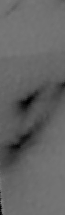

In [98]:
Image.open(os.path.join(image_dir, 'ESP_016517_2655_RED-0026.jpg')).convert('L').rotate(angle).crop(rect)

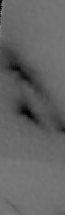

In [99]:
Image.open(os.path.join(image_dir, 'ESP_016517_2655_RED-0026-fv.jpg')).convert('L').rotate(-angle).crop(fv_rect)

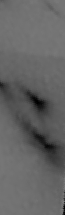

In [104]:
Image.open(os.path.join(image_dir, 'ESP_016517_2655_RED-0026-fh.jpg')).convert('L').rotate(-angle).crop(fh_rect)

Normally the angle would have been 360 - angle but since the file angles are actually clockwise rotations the initial counter clockwise rotations do the job

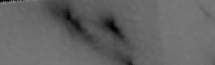

In [107]:
Image.open(os.path.join(image_dir, 'ESP_016517_2655_RED-0026-r90.jpg')).convert('L').rotate(angle).crop(r90_rect)

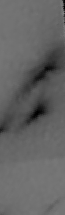

In [108]:
Image.open(os.path.join(image_dir, 'ESP_016517_2655_RED-0026-r180.jpg')).convert('L').rotate(angle).crop(r180_rect)

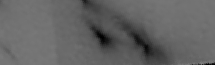

In [109]:
Image.open(os.path.join(image_dir, 'ESP_016517_2655_RED-0026-r270.jpg')).convert('L').rotate(angle).crop(r270_rect)

In [113]:
def transform_angle(angle: int, ttype: str) -> list:
    is_flip = ttype == 'fv' or ttype == 'fh'
    return -angle if is_flip else angle

## Remove Artifacts

We need to turn the rect strings back to arrays

In [141]:
df_art = df_art.reset_index()

In [ ]:
df_art['rect'] = df_art['rect'].apply(eval)

Manually verify on some interesting examples

In [134]:
for _, row in df_art.sort_values(by=['angle', 'image'], ascending=False).head(200).iterrows():
    img = os.path.join(image_dir, row['image'])
    img = Image.open(img).convert('L')

    ttype = row['transform']
    angle = transform_angle(row['angle'], ttype)
    rect = transform_rect(img.size, row['rect'], ttype)

    clean_img = img.rotate(angle).crop(rect).resize(img.size)

    conjoin = Image.new('L', (img.width * 2, img.height))
    conjoin.paste(im=img, box=(0, 0))
    conjoin.paste(im=clean_img, box=(img.width, 0))
    conjoin.save(os.path.join(temp_dir, row['image']))

Actually apply artifact removals

In [144]:
for _, row in df_art.iterrows():
    img_file = os.path.join(image_dir, row['image'])
    img = Image.open(img_file).convert('L')

    # backup the originals
    img.save(os.path.join(temp_dir, row['image']))

    ttype = row['transform']
    angle = transform_angle(row['angle'], ttype)
    rect = transform_rect(img.size, row['rect'], ttype)

    clean_img = img.rotate(angle).crop(rect).resize(img.size)
    clean_img.save(img_file)